In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm.notebook import tqdm

%matplotlib inline

# Сырые данные

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [27]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [28]:
users = pd.read_csv('data/users.csv') # Информация о городе проживания пользователя:
users.head()

,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk
3,12791716990148606332,msk
4,11642393216024958726,msk


In [29]:
orgs = pd.read_csv('data/organisations.csv') # Описание извлекаемых из отзывов аспектов. 
# Множество аспектов извлекается из отзыва с помощью NLP-алгоритма и может быть неточным.

In [30]:
columns = ['rubrics_id', 'features_id'] # create lists
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042..."
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704..."
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042..."


Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы.



`reviews.csv` - обучающее множество собрано за X = 1217 дней, тестовое множество – за последующие Y = 107 дней.

В этом файле дана информация об отзывах и оценках, оставленных некоторым множеством жителей Москвы и Санкт-Петерубрга в течение обучающего периода:

* `user_id`: идентификатор пользователя
* `org_id`: идентификатор организации
* `ts`: время отзыва (в днях от начала обучающего периода)
* `rating`: поставленная оценка
* `aspect_ids`: набор упомянутых в тексте отзыва аспектов.

In [31]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)

# encode users ids as numeric
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# # encode orgs ids as numeric
reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# # create lists
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews.head()

,user_id,org_id,rating,ts,aspects,user_city,org_city
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,msk
1,3121447338909258868,7184895086928047809,5.0,464,NaN,msk,msk
2,1970649778250883025,7184895086928047809,3.0,789,NaN,msk,msk
3,7554889464530643866,7184895086928047809,4.0,936,NaN,msk,msk
4,15907910894057053620,7184895086928047809,1.0,1143,NaN,msk,msk


**Отлично, теперь с отзывами будет удобно работать.**  Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

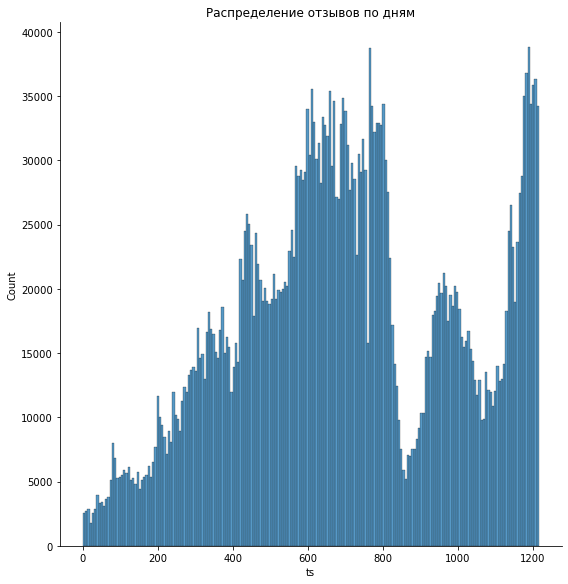

In [32]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

# Train-test split

In [33]:
from func import clear_df, extract_unique, count_unique, filter_reviews, train_test_split, process_reviews

In [34]:
reviews['ts'].max()

1216

**Всего в выборку попали отызывы за 1216 дней.**  Отложим в тестовую выборку отзывы за последние **100** дней.

In [35]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [36]:
len(X_test)

12044

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**.

`print_score` домножает реальное значение метрики на 100 так же, как и в контесте.

Подобная имплементация используется для оценки **submission**.

In [37]:
from func import MNAP, print_score

In [38]:
N = 20
MNAP_N = MNAP(N)

# Подходы без машинного обучения

## Случайные N мест

Попробуем предлагать пользователям случайные места из другого города. 

In [39]:
# spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
# msk_orgs = orgs[orgs['city'] == 'msk']['org_id']

test_users_with_locations = X_test.merge(users, on='user_id')

## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [40]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [41]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 4.21


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [42]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [43]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.40


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [44]:
from func import extract_top_by_rubrics

In [45]:
msk_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

In [46]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 5.77


# Время ML! Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении $i$-ой строки и $j$-ого столбца будет рейтинг, который $i$-ый пользователь выставил $j$-ой организации или же пропуск, если рейтинг не был установлен. 

In [47]:
from func import reduce_reviews, create_mappings, map_ids, interaction_matrix

## ALS

In [48]:
import implicit  # !pip install implicit

In [54]:
def make_predictions(interactions, X_test, N):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
    '''
    
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    
    print(interactions)
    
    (idx_to_uid, uid_to_idx), (idx_to_oid, oid_to_idx) = mappings

    base_model = implicit.als.AlternatingLeastSquares(
        factors=5, 
        iterations=75, 
        regularization=0.05, 
        random_state=42
    )
    
    base_model.fit(interactions.T)
    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_idx: idx_to_oid[org_idx], 
                recommendations[uid_to_idx[user_id]]
            )
        )
        
    return predictions.reset_index()


msk_interactions = interaction_matrix(train_reviews,
    train_reviews[train_reviews['user_city'] == 'msk'],
    test_users_with_locations[test_users_with_locations['city'] == 'msk'])

spb_interactions = interaction_matrix(train_reviews,
    train_reviews[train_reviews['user_city'] == 'spb'],
    test_users_with_locations[test_users_with_locations['city'] == 'spb'])       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

In [60]:
# list(msk_interactions[0])

In [55]:
msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

  (0, 1)	4.0
  (0, 16)	3.0
  (0, 21)	3.0
  (0, 23)	3.0
  (0, 27)	3.0
  (0, 6787)	4.0
  (0, 6801)	4.0
  (0, 8015)	4.0
  (0, 8031)	4.0
  (0, 9603)	4.0
  (0, 9693)	3.0
  (0, 9744)	4.0
  (0, 9802)	4.0
  (0, 9874)	5.0
  (0, 10005)	5.0
  (0, 10153)	4.0
  (0, 10327)	3.0
  (0, 10460)	4.0
  (0, 10528)	4.0
  (0, 10791)	5.0
  (0, 10818)	3.0
  (0, 10958)	4.0
  (0, 11621)	4.0
  (0, 11925)	4.0
  (0, 13646)	3.0
  :	:
  (32234, 7206)	10.0
  (32234, 7224)	10.0
  (32234, 7281)	10.0
  (32234, 7562)	10.0
  (32234, 7608)	6.0
  (32234, 8015)	10.0
  (32234, 10193)	8.0
  (32234, 10240)	6.0
  (32234, 12630)	6.0
  (32237, 6558)	10.0
  (32237, 9527)	8.0
  (32237, 10986)	5.0
  (32237, 11345)	8.0
  (32237, 12483)	8.0
  (32237, 13001)	4.0
  (32238, 6908)	8.0
  (32238, 9527)	10.0
  (32238, 9559)	10.0
  (32238, 9744)	10.0
  (32238, 9978)	10.0
  (32238, 9980)	10.0
  (32238, 12275)	10.0
  (32238, 14203)	10.0
  (32240, 1750)	4.0
  (32241, 10996)	10.0


ModelFitError: NaN encountered in factors

In [ ]:
print_score(MNAP_N(y_test, predictions))

# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

## Without ML

In [ ]:
# набор отзывов только от туристов
tourist_reviews = reviews[reviews['rating'] >= 4.0]
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

In [ ]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']
test_users.head()

In [ ]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)

predictions = test_users[['user_id']]
predictions['target'] = target

predictions.head()

In [ ]:
predictions.to_csv('answers.csv', index=None)

## With ML

In [ ]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')


test_msk_users = test_users[test_users['city'] == 'msk'][['user_id', 'city']]
test_spb_users = test_users[test_users['city'] == 'spb'][['user_id', 'city']]


msk_interactions = interaction_matrix(
    reviews,                                  
    reviews[reviews['user_city'] == 'msk'],
    test_msk_users
)

spb_interactions = interaction_matrix(
    reviews,
    reviews[reviews['user_city'] == 'spb'],
    test_spb_users
)

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

In [ ]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head()

In [ ]:
predictions.to_csv('answers_ml.csv', index=None)

In [ ]:
predictions['target'][0]